In [1]:
import math
from graphviz import Digraph
from graphlib import TopologicalSorter
import random

from typing import Callable, Union

class Value:
    val: float
    label: str
    children: list["Value"] | None
    op: str

    grad: float
    backprop: Callable[[], None]

    def __init__(
        self,
        val: float,
        label: str = "",
        children: list["Value"] | None = None,
        op: str = ""
    ):
        self.val = val
        self.label = label
        self.grad = 0
        self.backprop = lambda: None
        self.children = children if children else []
        self.op = op
    
    def __repr__(self) -> str:
        return f"Value(val={self.val})"

    def __add__(self, other: Union["Value", float, int]):
        other = other if isinstance(other, Value) else Value(val=other)
        output = Value(val=self.val + other.val, children=[self, other], op="+")

        # Output backprop updates the gradients OF ITS INPUTS
        # if output is Y and inputs are X and Z, backprop computes dy/dx and dy/dz
        def backprop():
            self.grad += output.grad
            other.grad += output.grad
        output.backprop = backprop
        return output

    def __mul__(self, other: Union["Value", float, int]):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(val=self.val * other.val, children=[self, other], op="*")

        def backprop():
            self.grad += other.val * output.grad
            other.grad += self.val * output.grad
        output.backprop = backprop
        return output
    
    def __pow__(self, other: float | int):
        if not isinstance(other, float) and not isinstance(other, int):
            raise Exception("Only supporting floats and ints for now.")
        output = Value(self.val ** other, children=[self], op="**")
        
        def backprop():
            self.grad += other * self.val ** (other - 1) * output.grad
        output.backprop = backprop
        return output
    
    def __truediv__(self, other: Union["Value", float, int]):
        return self * other**-1

    def exp(self):
        output = Value(math.exp(self.val), children=[self], op="exp")
        def backprop():
            self.grad += math.exp(self.val) * output.grad
        output.backprop = backprop
        return output

    def tanh(self):
        e = (self * 2).exp()
        output = Value((e.val-1)/(e.val+1), children=[self], op="tanh")
        def backprop():
            self.grad += (1 - (output.val)**2) * output.grad
        output.backprop = backprop
        return output

    def topological_sort(self) -> list["Value"]:
        """
        Build topological sort of inputs (for backpropogation)
        """
        order = []
        for children in self.children:
            order.extend(children.topological_sort())
        order.append(self)
        return order

    def backwards(self):
        """
        Backpropogation!
        """
        topsort = self.topological_sort()
        for value in topsort[::-1]:
            value.backprop()

    def __sub__(self, other: Union["Value", float, int]):
        return self.__add__(other * -1)
    
    def __rmul__(self, other: float | int):
        return self.__mul__(other)

    def __rsub__(self, other: float | int):
        return self.__sub__(other)

    def graph(self, format='svg', rankdir='LR'):
        graph = Digraph(format=format, graph_attr={'rankdir': rankdir})
        def build(n: "Value"):    
            node_id = str(id(n))
            op_id = None
            graph.node(
                name=node_id,
                label = "{ %s | val %.4f | grad %.4f }" % (n.label, n.val, n.grad),
                shape='record'
            )
            if n.op:
                op_id = node_id + str(id(n.op))
                graph.node(
                    name=op_id,
                    label=n.op,
                    shape='record'
                )
                graph.edge(op_id, node_id)

                for child in n.children:
                    child_id = str(id(child))
                    graph.edge(child_id, op_id)

                    build(child)
        build(self)
        return graph
    

class Neuron:

    def __init__(self, n_inputs: int, nonlin: bool = False):
        self.nonlin = nonlin
        self.weights = [Value(random.uniform(-1,1)) for _ in range(n_inputs)]
        self.bias = Value(0)

    def __call__(self, x: list[float]) -> Value:
        print(len(self.weights), len(x))
        act = sum((wi*xi for wi,xi in zip(self.weights, x)), self.bias)
        return act.tanh() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]
    
    def __repr__(self):
        return f"Linear(tanh({len(self.weights)}))"


class Layer:
    
    def __init__(self, n_inputs: int, n_outputs: int, **kwargs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.neurons = [Neuron(n_inputs, **kwargs) for _ in range(n_outputs)]
        self.kwargs = kwargs
    
    def __call__(self, x: list[float]) -> list[Value]:
        return [n(x) for n in self.neurons]

    def parameters(self):
        params = []
        for n in self.neurons:
            params.extend(n.parameters())
        return params

    def __repr__(self):
        return f"Layer(n_inputs={self.n_inputs}, outputs={self.n_outputs}, nonlin={self.kwargs.get('nonlin', False)}))"


class MLP:
    
    def __init__(self, n_inputs: int, n_outputs: list[int]):
        self.n_inputs = n_inputs

        sz = [n_inputs] + n_outputs
        self.layers = []
        for i in range(1, len(sz)):
            layer = Layer(n_inputs=sz[i-1], n_outputs=sz[i], nonlin=(i != len(sz)-1))
            self.layers.append(layer)
    
    def __call__(self, x: list[float]) -> list[Value]:
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for l in self.layers:
            params.extend(l.parameters())
        return params
    
    def __repr__(self):
        return f"MLP([{',\n'.join(l.__repr__() for l in self.layers)}])"

    def graph(self, format="svg", rankdir="LR", layer_spacing=4.0, node_spacing=0.75):
        """
        Build a graph of the MLP architecture using graphlib.TopologicalSorter.
        Each neuron and connection (layer-to-layer) is represented as a node/edge.
        """
        ts = TopologicalSorter()
        node_names = {}

        # Add a synthetic input layer if desired
        input_nodes = [f"I{i}" for i in range(self.n_inputs)]
        for i in input_nodes:
            ts.add(i)

        # Assign unique identifiers for each layer and neuron
        for l_idx, layer in enumerate(self.layers):
            for n_idx, neuron in enumerate(layer.neurons):
                node_id = f"L{l_idx}_N{n_idx}"
                node_names[neuron] = node_id
                # Each neuron depends on all neurons from the previous layer
                if l_idx > 0:
                    for prev_neuron in self.layers[l_idx - 1].neurons:
                        ts.add(node_id, node_names[prev_neuron])
                else:
                    # Input layer neurons
                    ts.add(node_id, *input_nodes)

        # Create the topological order
        ts.static_order()

        # Build a Graphviz visualization
        dot = Digraph(format=format, graph_attr={
            'rankdir': rankdir,
            'ranksep': str(layer_spacing),
            'nodesep': str(node_spacing)
        })
        dot.attr('node', shape='circle')

        # Draw nodes
        with dot.subgraph(name="input") as sub:
            sub.attr(label="Input Layer")
            for i_idx, input_node_id in enumerate(input_nodes):
                sub.node(input_node_id, label=f"I{i_idx}")

        for l_idx, layer in enumerate(self.layers):
            with dot.subgraph(name=f"cluster_{l_idx}") as sub:
                sub.attr(label=f"Layer {l_idx}")
                for n_idx, neuron in enumerate(layer.neurons):
                    node_id = f"L{l_idx}_N{n_idx}"
                    sub.node(node_id, label=node_id)

        # Draw edges
        for l_idx in range(len(self.layers)):
            if l_idx == 0:
                for n_idx, neuron in enumerate(self.layers[1].neurons):
                    node_id = f"L{l_idx}_N{n_idx}"
                    for input_node_id in input_nodes:
                        dot.edge(input_node_id, node_id)
            else:
                for n_idx, neuron in enumerate(self.layers[l_idx].neurons):
                    node_id = f"L{l_idx}_N{n_idx}"
                    for p_idx, prev_neuron in enumerate(self.layers[l_idx - 1].neurons):
                        prev_id = f"L{l_idx-1}_N{p_idx}"
                        dot.edge(prev_id, node_id)

        return dot

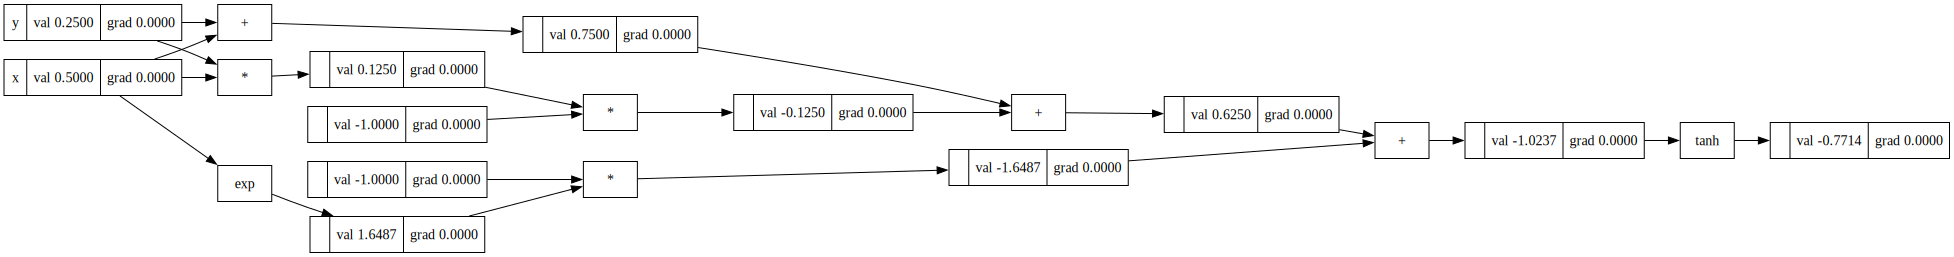

In [2]:
x = Value(0.5, label="x")
y = Value(0.25, label="y")
z = x + y - x*y - x.exp()
z = z.tanh()
z.graph()

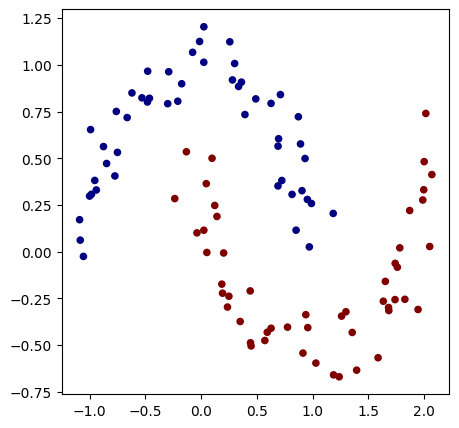

In [3]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline

X, y = make_moons(n_samples=100, noise=0.1)
X_values = [list(map(Value, xrow)) for xrow in X]

# Visualize
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

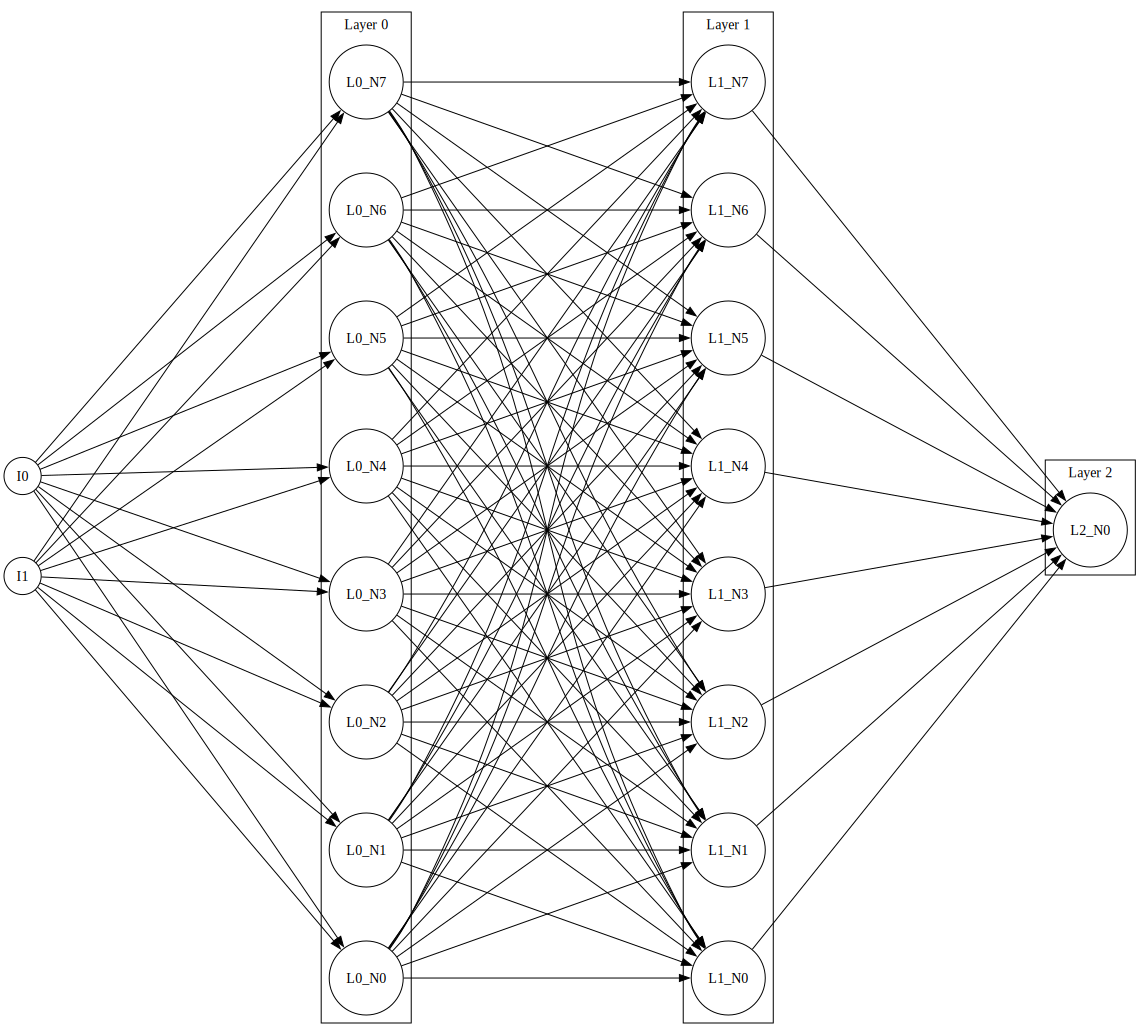

In [4]:
# Model
model = MLP(2, [8, 8, 1])
model.graph()

In [5]:


# Loss function
def loss(model: MLP, X_values: list[list[Value]]):
    pass
